<a href="https://colab.research.google.com/github/chervovn04/DLS/blob/main/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
# CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
import os

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(cv2.imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: cv2.resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
DATA, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
data = np.transpose(DATA[:, :, :, [2, 1, 0]], (0, 3, 1, 2))

In [ ]:
data = torch.from_numpy(data).float() / 255

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.1, random_state=42)

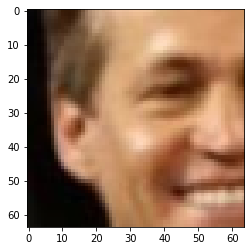

In [ ]:
plt.imshow(X_train[0].permute(1, 2, 0));

In [ ]:
batch_size = 64
train_full = X_train.shape[0] // batch_size
test_full = X_test.shape[0] // batch_size

X_train = X_train[:batch_size * train_full]
X_test = X_test[:batch_size * test_full]

In [ ]:
X_train.shape, X_test.shape

(torch.Size([11776, 3, 64, 64]), torch.Size([1280, 3, 64, 64]))

In [ ]:
X_train = X_train.reshape(-1, 64, 3, 64, 64)
X_test = X_test.reshape(-1, 64, 3, 64, 64)

In [ ]:
X_train.shape, X_test.shape

(torch.Size([184, 64, 3, 64, 64]), torch.Size([20, 64, 3, 64, 64]))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16*16 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d
from copy import deepcopy

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
        self.encoder = nn.Sequention()
        self.decoder = nn.Sequention()
    
    def forward(self, x):
        print(x.shape)
        return x

class Autoencoder(nn.Module):
    def __init__(self, lat_size=dim_code):
        super(Autoencoder, self).__init__()

        # encode
        # layer 0
        self.enc_layer0 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.enc_batchnorm0 = nn.BatchNorm2d(6)
        self.enc_maxpool0 = nn.MaxPool2d(2)

        # layer 1
        self.enc_layer1 = nn.Conv2d(6, 9, kernel_size=3, padding=1)
        self.enc_batchnorm1 = nn.BatchNorm2d(9)

        # layer 2
        self.enc_layer2 = nn.Conv2d(9, 6, kernel_size=3, padding=1)
        self.enc_batchnorm2 = nn.BatchNorm2d(6)
        self.enc_maxpool2 = nn.MaxPool2d(2)

        # layer 3
        self.enc_layer3 = nn.Conv2d(6, 3, kernel_size=3, padding=1)
        self.enc_batchnorm3 = nn.BatchNorm2d(3)

        # layer 4
        self.enc_layer4 = nn.Conv2d(3, 1, kernel_size=3, padding=1)


        # decode
        # layer 0
        self.dec_layer0 = nn.ConvTranspose2d(1, 3, kernel_size=3, padding=1)
        self.dec_batchnorm0 = nn.BatchNorm2d(3)

        # layer 1
        self.dec_layer1 = nn.ConvTranspose2d(3, 6, kernel_size=3, padding=1)
        self.dec_batchnorm1 = nn.BatchNorm2d(6)

        # layer 2
        self.dec_layer2 = nn.ConvTranspose2d(6, 9, kernel_size=2, stride=2)
        self.dec_batchnorm2 = nn.BatchNorm2d(9)

        # layer 3
        self.dec_layer3 = nn.ConvTranspose2d(9, 6, kernel_size=3, padding=1)
        self.dec_batchnorm3 = nn.BatchNorm2d(6)

        # layer 4
        self.dec_layer4 = nn.ConvTranspose2d(6, 3, kernel_size=2, stride=2)
        
    def forward(self, x):
        # encode
        x = F.relu(self.enc_batchnorm0(self.enc_layer0(x))) # 0
        x = self.enc_maxpool0(x)
        x = F.relu(self.enc_batchnorm1(self.enc_layer1(x))) # 1
        # print(self.enc_layer2)
        x = F.relu(self.enc_batchnorm2(self.enc_layer2(x))) # 2
        x = self.enc_maxpool2(x)
        x = F.relu(self.enc_batchnorm3(self.enc_layer3(x))) # 3
        x = self.enc_layer4(x) # 4

        latent_code = nn.Flatten()(x)
        
        # decode
        x = F.relu(self.dec_batchnorm0(self.dec_layer0(x))) # 0
        x = F.relu(self.dec_batchnorm1(self.dec_layer1(x))) # 1
        x = F.relu(self.dec_batchnorm2(self.dec_layer2(x))) # 2
        x = F.relu(self.dec_batchnorm3(self.dec_layer3(x))) # 3
        x = self.dec_layer4(x) # 4
        reconstruction = x

        return reconstruction, latent_code
        
    def decode(self, x):
        x = torch.reshape(x, (-1, 1, 16, 16))
        x = F.relu(self.dec_batchnorm0(self.dec_layer0(x))) # 0
        x = F.relu(self.dec_batchnorm1(self.dec_layer1(x))) # 1
        x = F.relu(self.dec_batchnorm2(self.dec_layer2(x))) # 2
        x = F.relu(self.dec_batchnorm3(self.dec_layer3(x))) # 3
        x = self.dec_layer4(x) # 4
        return x

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
autoencoder

Autoencoder(
  (enc_layer0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_layer1): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer2): Conv2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_layer3): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer4): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from tqdm import tqdm
from google.colab import output

In [ ]:
def train(train_data, test_data, epoches, model, criterion, optimizer, scheduler):
    train_error = []
    val_error = []
    for epoch in tqdm(range(epoches)):
        # train
        error = 0
        model.train()
        for i in range(len(X_train)):
            X_batch = X_train[i].to(device)
            X_pred = model(X_batch)[0]

            optimizer.zero_grad()
            loss = criterion(X_pred, X_batch)
            loss.backward()
            optimizer.step()
            error += (loss / len(X_train)).item()
        train_error.append(error)

        scheduler.step()

        # eval
        error = 0
        model.eval()
        for i in range(len(X_test)):
            X_batch = X_train[i].to(device)
            X_pred = model(X_batch)[0]
            loss = criterion(X_pred, X_batch)
            error += (loss / len(X_test)).item()
        val_error.append(error)

        output.clear()

        fig = plt.figure(figsize=(6, 6))

        fig.add_subplot(2, 2, 1)
        plt.imshow(X_test[0][0].permute(1, 2, 0));
        fig.add_subplot(2, 2, 2)
        plt.imshow(model(X_test.to(device)[0][0].unsqueeze(0))[0].squeeze().permute(1, 2, 0).clip(0, 1).detach().cpu());
        fig.add_subplot(2, 2, 3)
        plt.plot(train_error)
        plt.plot(val_error)
        plt.legend(['train', 'validation'])
        print('train_loss: ', train_error[-1])
        print('val_loss', val_error[-1])
        plt.show()



train_loss:  0.0038865842816449003
val_loss 0.0039020056574372575


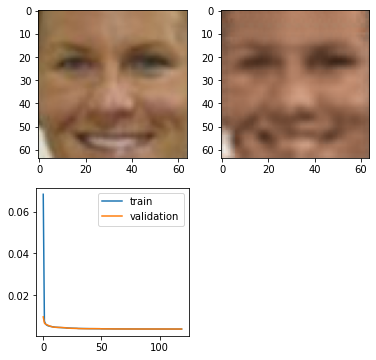

100%|██████████| 120/120 [04:50<00:00,  2.42s/it]


In [ ]:
train(X_train, X_test, 120, autoencoder, criterion, optimizer, scheduler)

In [ ]:
autoencoder.eval()

Autoencoder(
  (enc_layer0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_layer1): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer2): Conv2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_layer3): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_batchnorm3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer4): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de

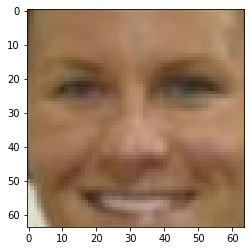

In [ ]:
plt.imshow(X_test[0][0].permute(1, 2, 0));

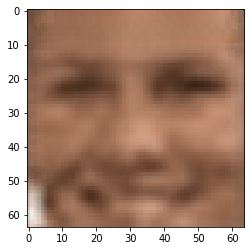

In [ ]:
plt.imshow(autoencoder(X_test.to(device)[0][0].unsqueeze(0))[0].squeeze().permute(1, 2, 0).clip(0, 1).detach().cpu());

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

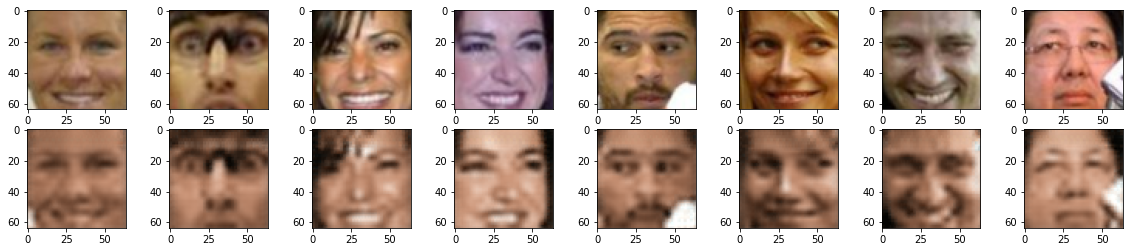

In [ ]:
fig = plt.figure(figsize=(20, 4))
for i in range(8):
    fig.add_subplot(2, 8, i + 1)
    plt.imshow(X_test[0][i].permute(1, 2, 0));
for i in range(8):
    fig.add_subplot(2, 8, 8 + i + 1)
    plt.imshow(autoencoder(X_test.to(device)[0][i].unsqueeze(0))[0].squeeze().permute(1, 2, 0).clip(0, 1).detach().cpu());

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
x = autoencoder.to('cpu')(X_train[0][0].unsqueeze(0))[1] / 20
for i in range(1, 20):
    x += autoencoder.to('cpu')(X_train[0][i].unsqueeze(0))[1] / 20
x = torch.reshape(x, (16, 16))

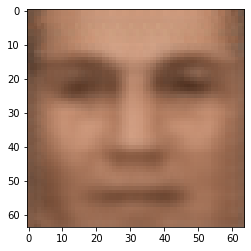

In [ ]:
plt.imshow(autoencoder.decode(x)[0].permute(1, 2, 0).clip(0, 1).detach().cpu());

In [ ]:
x = autoencoder.to(device)(X_test.to(device)[0][0].unsqueeze(0))[1]
y = autoencoder(X_test.to(device)[0][1].unsqueeze(0))[1] 

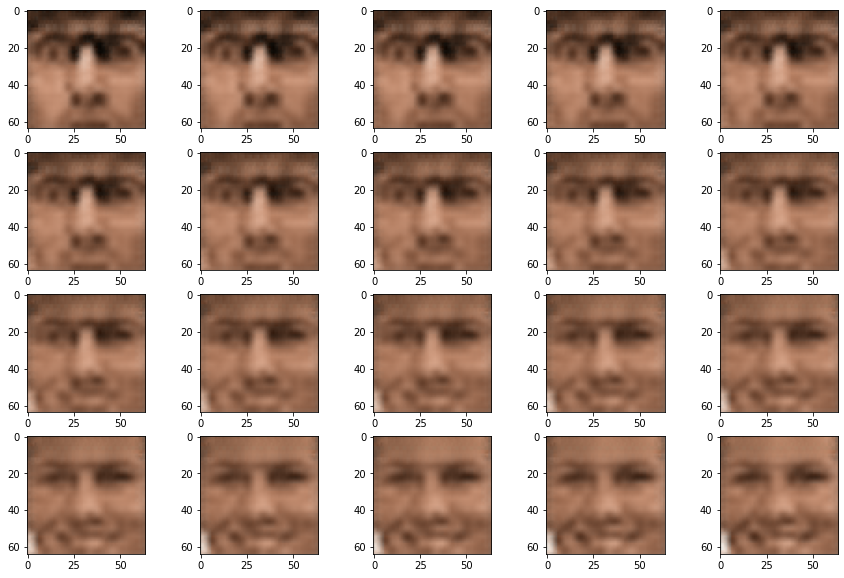

In [ ]:
fig = plt.figure(figsize=(15, 10))
id = 1
for i in np.linspace(0, 1, 20):
    fig.add_subplot(4, 5, id)
    id += 1
    plt.imshow(autoencoder.decode(x * i + y * (1 - i))[0].permute(1, 2, 0).clip(0, 1).detach().cpu());

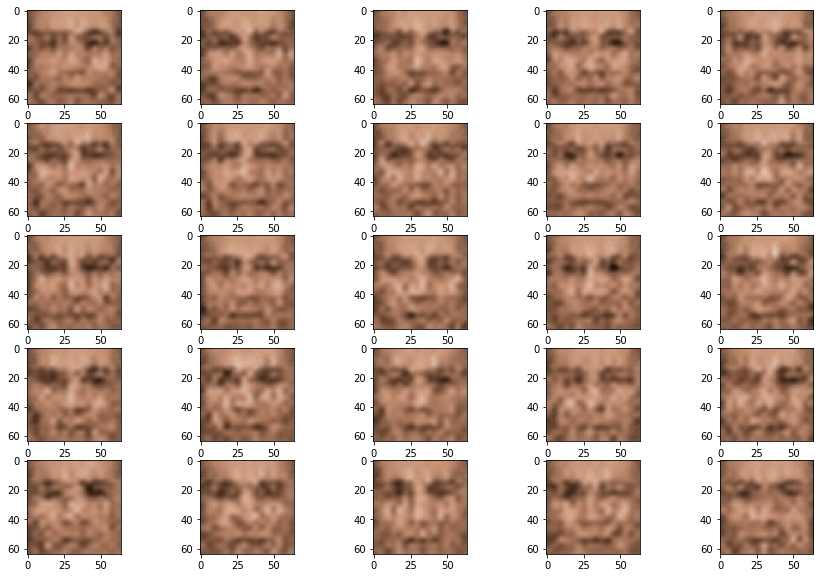

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
autoencoder.to(device)
N = 25
fig = plt.figure(figsize=(15, 10))
id = 1
for i in range(N):
    z = torch.normal(mean=x, std=0.05).to(device)
    output = autoencoder.decode(z)
    fig.add_subplot(5, 5, id)
    id += 1
    plt.imshow(output[0].permute(1, 2, 0).clip(0, 1).detach().cpu())

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
normal_ids = np.arange(attrs.shape[0])[abs(attrs.Smiling) < 0.5][:37]
smiling_ids = np.arange(attrs.shape[0])[attrs.Smiling > 2.5]

In [ ]:
normal_ids.shape, smiling_ids.shape

((37,), (37,))

In [ ]:
# photos = np.transpose(DATA[:, :, :, [2, 1, 0]], (0, 3, 1, 2))
photos = torch.Tensor(DATA[:, :, :, [2, 1, 0]]).permute(0, 3, 1, 2) / 255

In [ ]:
normal_latent = torch.zeros(256).to(device)
smiling_latent = torch.zeros(256).to(device)
for photo in photos[normal_ids]:
    normal_latent += autoencoder(photo.unsqueeze(0).to(device))[1][0] / normal_ids.shape[0]
for photo in photos[smiling_ids]:
    smiling_latent += autoencoder(photo.unsqueeze(0).to(device))[1][0] / smiling_ids.shape[0]

In [ ]:
smile = smiling_latent - normal_latent

In [ ]:
def add_smile(photo):
    fig = plt.figure(figsize=(10, 5))

    fig.add_subplot(1, 3, 1)
    plt.imshow(photo.permute(1, 2, 0))

    fig.add_subplot(1, 3, 2)
    latent = autoencoder(photo.unsqueeze(0).to(device))[1][0]
    result = autoencoder.decode(latent).squeeze().permute(1, 2, 0).clip(0, 1)
    plt.imshow(result.detach().cpu())

    fig.add_subplot(1, 3, 3)
    latent = autoencoder(photo.unsqueeze(0).to(device))[1][0] + smile
    result = autoencoder.decode(latent).squeeze().permute(1, 2, 0).clip(0, 1)
    plt.imshow(result.detach().cpu())

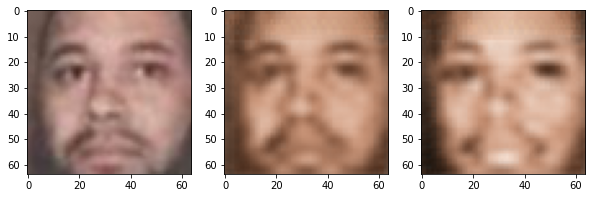

In [ ]:
add_smile(photos[normal_ids[0]])

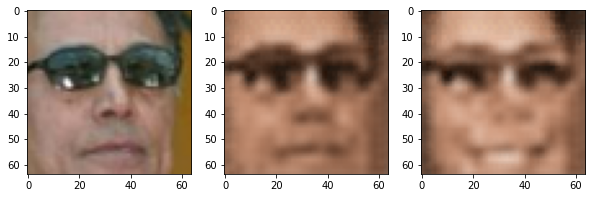

In [ ]:
add_smile(photos[normal_ids[1]])

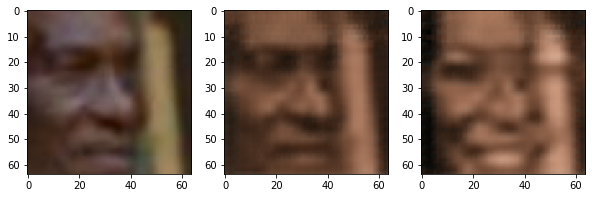

In [ ]:
add_smile(photos[normal_ids[2]])

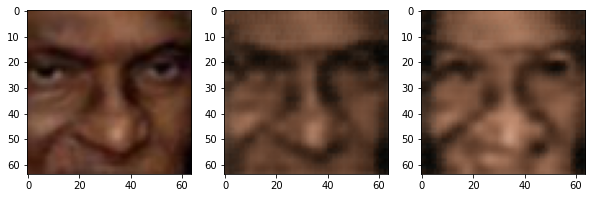

In [ ]:
add_smile(photos[normal_ids[3]])

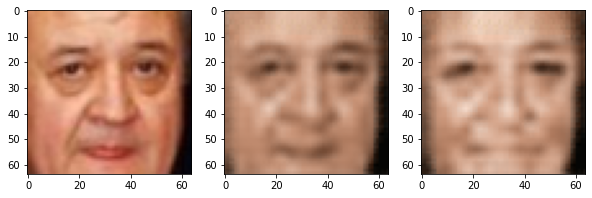

In [ ]:
add_smile(photos[normal_ids[4]])

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
from numpy.core.numeric import NAN

class VAE(nn.Module):
    def __init__(self, lat_size):
        super().__init__()
        
        self.lat_size = lat_size

        # encoder
        self.enc_layer0 = nn.Linear(28*28, 512)
        self.enc_layer1 = nn.Linear(512, 256)
        self.enc_layer20 = nn.Linear(256, lat_size)
        self.enc_layer21 = nn.Linear(256, lat_size)

        # decoder
        self.dec_layer0 = nn.Linear(lat_size, 256)
        self.dec_layer1 = nn.Linear(256, 512)
        self.dec_layer2 = nn.Linear(512, 28*28)

    def encode(self, x):
        x = torch.reshape(x, (-1, 28*28))
        x = F.relu(self.enc_layer0(x))
        x = F.relu(self.enc_layer1(x))
        return self.enc_layer20(x), self.enc_layer21(x)
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            return mu + torch.randn_like(torch.exp(logsigma)) * torch.exp(logsigma)
        else:
            return mu
    
    def decode(self, x):
        x = F.relu(self.dec_layer0(x))
        x = F.relu(self.dec_layer1(x))
        x = self.dec_layer2(x)
        x = torch.reshape(x, (-1, 1, 28, 28))
        return torch.sigmoid(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)
        reconstruction = self.decode(z)

        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logvar, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logvar)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE(5).to(device)
# autoencoder = VariationalAutoencoder(28*28).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-3)

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
def train(train_data, test_data, epoches, model, criterion, optimizer):

    test_item = next(iter(test_data))[0][0][0]

    train_loss = []
    test_loss = []
    for epoch in tqdm(range(epoches)):

        mean_loss = 0 # train
        model.train()
        for X_batch, y_batch in train_data:
            X_batch = X_batch.to(device)
            mu, logvar, X_pred = model(X_batch)
            loss = criterion(X_batch, mu, logvar, X_pred)
            mean_loss += loss.item() / len(train_data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(mean_loss)
        
        mean_loss = 0 # eval
        model.eval() 
        for X_batch, y_batch in test_data:
            X_batch = X_batch.to(device)
            mu, logvar, X_pred = model(X_batch)
            loss = criterion(X_batch, mu, logvar, X_pred)
            mean_loss += loss.item() / len(test_data)

        test_loss.append(mean_loss)

        clear_output() # show stats
        print(train_loss[-1])
        fig = plt.figure(figsize=(10, 10))

        fig.add_subplot(2, 2, 1)
        plt.plot(train_loss)
        plt.plot(test_loss)
        plt.legend(['train', 'test'])
        
        fig.add_subplot(2, 2, 3)
        plt.imshow(test_item, cmap='gray')

        fig.add_subplot(2, 2, 4)
        plt.imshow(model(test_item.to(device))[2][0][0].detach().cpu(), cmap='gray')

        plt.show()


7095.33947727879


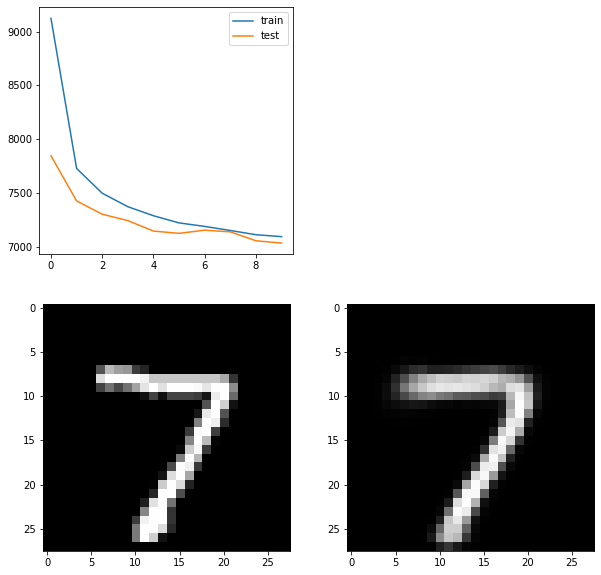

100%|██████████| 10/10 [01:24<00:00,  8.45s/it]


In [ ]:
train(train_loader, test_loader, 10, autoencoder, criterion, optimizer)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()

VAE(
  (enc_layer0): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer1): Linear(in_features=512, out_features=256, bias=True)
  (enc_layer20): Linear(in_features=256, out_features=5, bias=True)
  (enc_layer21): Linear(in_features=256, out_features=5, bias=True)
  (dec_layer0): Linear(in_features=5, out_features=256, bias=True)
  (dec_layer1): Linear(in_features=256, out_features=512, bias=True)
  (dec_layer2): Linear(in_features=512, out_features=784, bias=True)
)

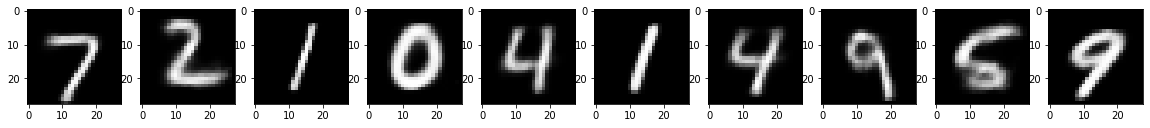

In [ ]:
N = 10
fig = plt.figure(figsize=(20, 20))
X_first, y_first = next(iter(test_loader))
for i in range(N):
    X = X_first[i].to(device).unsqueeze(0)
    fig.add_subplot(1, N, i + 1)
    plt.imshow(autoencoder(X)[2].squeeze().detach().cpu(), cmap='gray')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

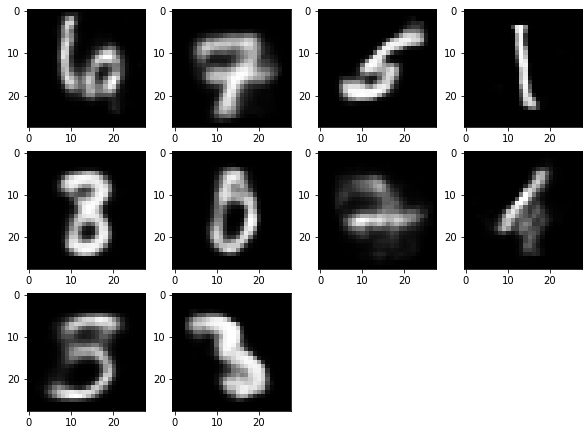

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.stack([torch.normal(0, 1, size=(5,)) for i in range(10)]).to(device)
output = autoencoder.decode(z)
fig = plt.figure(figsize=(10, 10))
for i, number in enumerate(output):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(number.squeeze().detach().cpu(), cmap='gray')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_train = []
for X, y in test_loader:
    for i in range(X.shape[0]):
        X_train.append(torch.reshape(autoencoder.encode(X[i].to(device))[0].detach().cpu(), (-1,)).tolist())
X_train = np.array(X_train)
X_train.shape

(10000, 5)

In [ ]:
X_pos = TSNE().fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
color = []
for X, y in test_loader:
    for i in range(X.shape[0]):
        color.append(y[i])
color = np.array(color)
color.shape

(10000,)

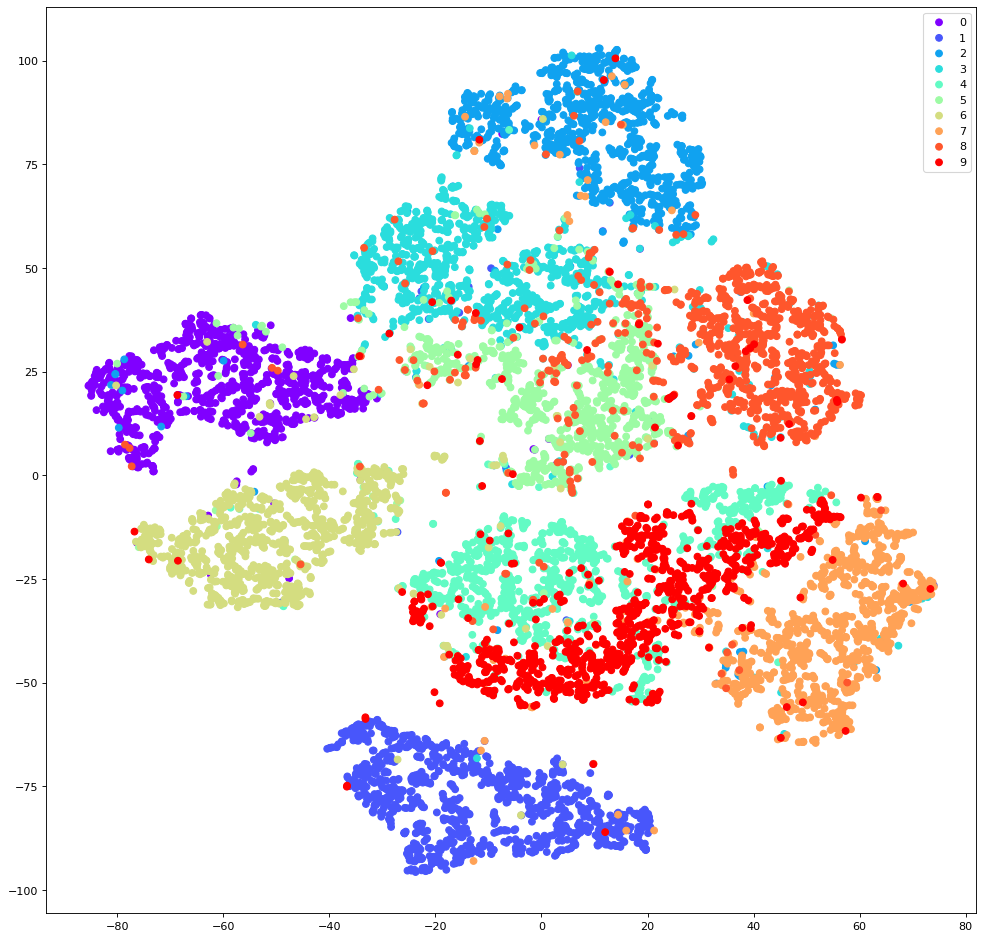

In [ ]:
from matplotlib import cm
plt.figure(figsize=(15, 15), dpi=80)
colors = cm.rainbow(np.linspace(0, 1, 10))
for t_color in range(10):
    plt.scatter(X_pos[:, 0][color==t_color], X_pos[:, 1][color==t_color], color=colors[color][color==t_color]);
plt.legend(range(10));

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, lat_size, class_count):
        super().__init__()

        self.lat_size = lat_size

        self.enc_layer0 = nn.Linear(28*28, 512)
        self.enc_layer1 = nn.Linear(512, 256)
        self.enc_layer20 = nn.Linear(256, lat_size)
        self.enc_layer21 = nn.Linear(256, lat_size)

        self.dec_layer0 = nn.Linear(lat_size + class_count, 256)
        self.dec_layer1 = nn.Linear(256, 512)
        self.dec_layer2 = nn.Linear(512, 28*28)

    def encode(self, x, class_num):
        x = torch.reshape(x, (-1, 28*28))
        x = F.relu(self.enc_layer0(x))
        x = F.relu(self.enc_layer1(x))
        return self.enc_layer20(x), self.enc_layer21(x), class_num
    
    def gaussian_sampler(self, mu, logvar):
        if self.training:
            return mu + torch.randn_like(mu) * torch.exp(logvar / 2)
        else:
            return mu
    
    def decode(self, x, class_num):
        x = torch.cat((x, F.one_hot(class_num, 10)), axis=1)
        x = F.relu(self.dec_layer0(x))
        x = F.relu(self.dec_layer1(x))
        x = torch.sigmoid(self.dec_layer2(x))
        x = torch.reshape(x, (-1, 1, 28, 28))
        return x

    def forward(self, x, class_num):
        mu, logvar, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logvar)
        x = self.decode(z, class_num)
        return mu, logvar, x

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def KL_divergence(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logvar, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logvar)

In [ ]:
criterion = loss_vae

autoencoder = CVAE(5, 10).to(device)
# autoencoder = VariationalAutoencoder(28*28).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-3)

In [ ]:
def train(train_data, test_data, epoches, model, criterion, optimizer):

    test_item = next(iter(test_data))[0][0][0].to(device)
    test_class = next(iter(test_data))[1][0].to(device).unsqueeze(0)

    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epoches)):

        mean_loss = 0 # train
        model.train()
        for X_batch, y_batch in train_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mu, logvar, X_pred = model(X_batch, y_batch)
            loss = criterion(X_batch, mu, logvar, X_pred)
            mean_loss += loss.item() / len(train_data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(mean_loss)
        
        mean_loss = 0 # eval
        model.eval() 
        for X_batch, y_batch in test_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mu, logvar, X_pred = model(X_batch, y_batch)
            loss = criterion(X_batch, mu, logvar, X_pred)
            mean_loss += loss.item() / len(test_data)

        test_loss.append(mean_loss)

        clear_output() # show stats
        print(train_loss[-1])
        fig = plt.figure(figsize=(10, 10))

        fig.add_subplot(2, 2, 1)
        plt.plot(train_loss)
        plt.plot(test_loss)
        plt.legend(['train', 'test'])
        
        fig.add_subplot(2, 2, 3)
        plt.imshow(test_item.detach().cpu(), cmap='gray')

        fig.add_subplot(2, 2, 4)
        plt.imshow(model(test_item, test_class)[2][0][0].detach().cpu(), cmap='gray')

        plt.show()

7064.461721977451


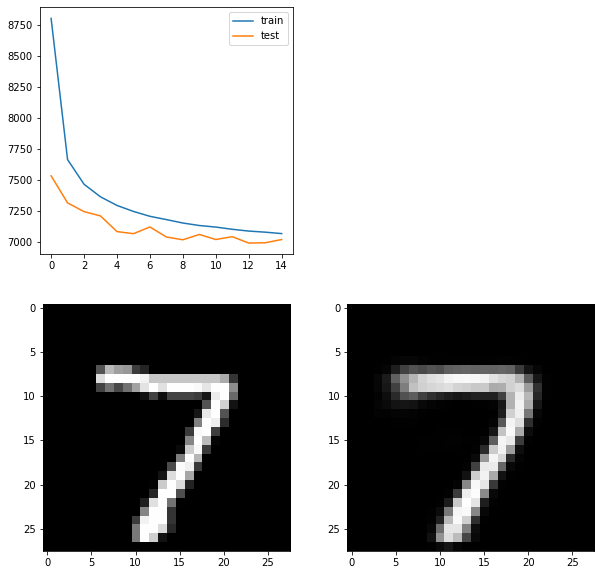

100%|██████████| 15/15 [02:10<00:00,  8.72s/it]


In [ ]:
train(train_loader, test_loader, 15, autoencoder, criterion, optimizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


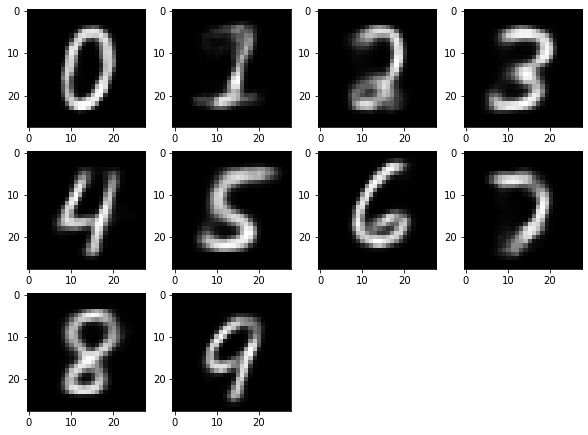

In [ ]:
z = torch.stack([torch.zeros(5) for i in range(10)]).to(device)
class_num = torch.Tensor.long(torch.range(0, 9)).to(device)
output = autoencoder.decode(z, class_num)
fig = plt.figure(figsize=(10, 10))
for i, number in enumerate(output):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(number.squeeze().detach().cpu(), cmap='gray')

Splendid! Вы великолепны!


### Latent Representations

*Давайте* посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
X_train = []
for X, y in test_loader:
    for i in range(X.shape[0]):
        X_train.append(torch.reshape(autoencoder.encode(X[i].to(device), y[i].unsqueeze(0).to(device))[0].detach().cpu(), (-1,)).tolist())
X_train = np.array(X_train)
X_train.shape

(10000, 5)

In [ ]:
X_pos = TSNE().fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
color = []
for X, y in test_loader:
    for i in range(X.shape[0]):
        color.append(y[i])
color = np.array(color)
color.shape

(10000,)

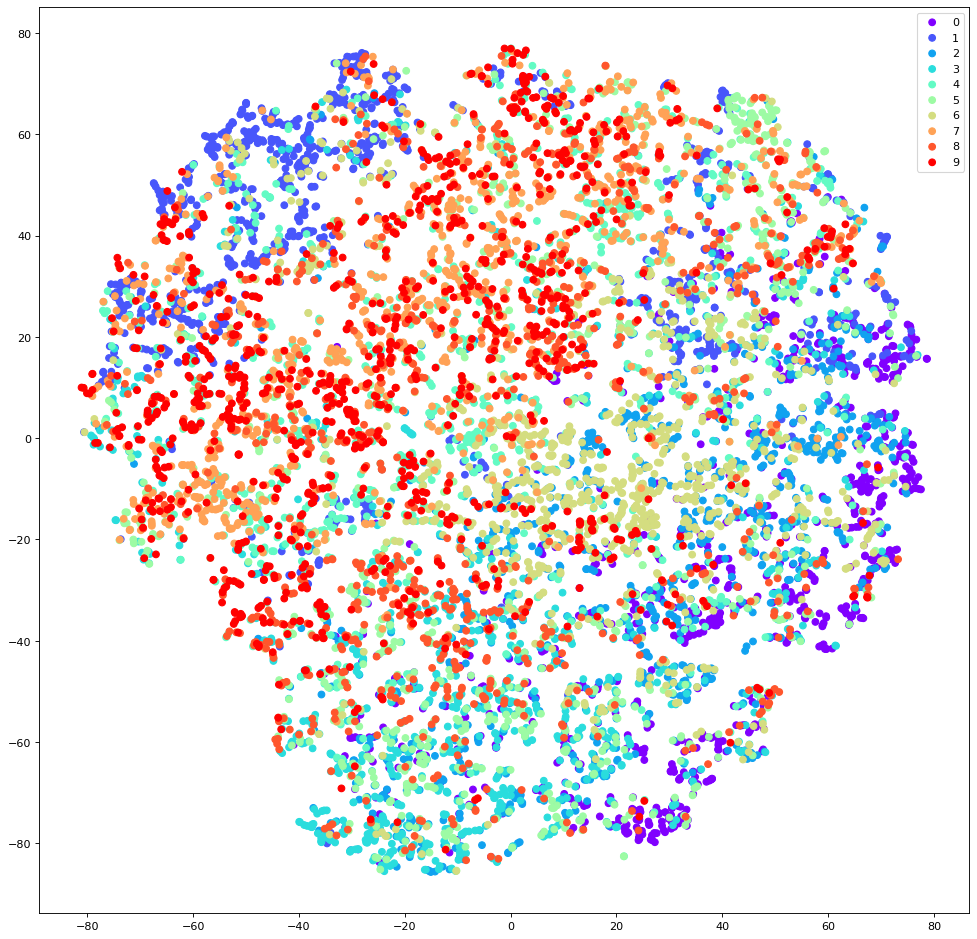

In [ ]:
from matplotlib import cm
plt.figure(figsize=(15, 15), dpi=80)
colors = cm.rainbow(np.linspace(0, 1, 10))
for t_color in range(10):
    plt.scatter(X_pos[:, 0][color==t_color], X_pos[:, 1][color==t_color], color=colors[color][color==t_color]);
plt.legend(range(10));

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Да отличаются, при CVAE в латентное пространство не нежно класть информацию о форме фигуры. Поэтому оптимальнее все расположить в похожих облаках с центром в 0

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>